In [4]:
# script to merge 2010 and 2015 bus data into a combined panel

import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as smf

from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import compare
from matplotlib import pyplot as plt


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)


%matplotlib inline

In [5]:
# read the data and calculate some derived fields
data = pd.read_csv('difffile_SFTAZ_Bus.csv', thousands = ',')
data.head()

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0  SFTAZ  MTCTAZ       TOD2 AGENCY_ID  COUNTY  AREATYPE  DISTRICT  \
0           0      1     156  0300-0859     SFMTA       1         3         8   
1           1      1     156  0900-1559     SFMTA       1         3         8   
2           2      1     156  1600-1859     SFMTA       1         3         8   
3           3      1     156  1900-0259     SFMTA       1         3         8   
4           4      2     164  0300-0859         0       1         3         8   

   SUPERDST  DIST15  DIST22  DIST40  DIST51    ON_2010    ON_2015    ON_DIFF  \
0         3       9       5       5      31   4.825000  18.258993  13.433993   
1         3       9       5       5      31  12.561917  14.134235   1.572318   
2         3       9       5       5      31  11.330133   6.555133  -4.775000   
3         3       9       5       5      31   8.529041   3.291554  -5.237488   
4         3      10      14       5      36   0.000000   0.000000   0.000000   

   ON_REL_DIFF   ON_SCALE   OFF_2010   OFF_2015   OFF_DIFF  OFF_REL_DIFF  \
0     2.784247  33.053777  18.918421  48.488181  29.569760      1.563014   
1     0.125165   6.490189  91.143832  99.285481   8.141649      0.089327   
2    -0.421443 -13.677581  53.578274  66.476155  12.897881      0.240730   
3    -0.614077 -11.493015  28.902800  34.500699   5.597899      0.193680   
4     0.000000   0.000000   0.000000   0.000000   0.000000      0.000000   

   OFF_SCALE  AVG_RIDE_2010  AVG_RIDE_2015  AVG_RIDE_DIFF  AVG_RIDE_REL_DIFF  \
0  18.555652      11.871711      33.373587      21.501876           1.811186   
1   4.631887      51.852874      56.709858       4.856983           0.093669   
2   7.812690      32.454204      36.515644       4.061440           0.125144   
3   3.624903      18.715921      18.896126       0.180206           0.009628   
4   0.000000       0.000000       0.000000       0.000000           0.000000   

   AVG_RIDE_SCALE  ROUTES_2010  ROUTES_2015  ROUTES_DIFF  ROUTES_REL_DIFF  \
0       21.501876          2.0          3.0          1.0              0.5   
1        4.856983          2.0          2.0          0.0              0.0   
2        4.061440          2.0          2.0          0.0              0.0   
3        0.180206          2.0          3.0          1.0              0.5   
4        0.000000          0.0          0.0          0.0              0.0   

   ROUTES_SCALE  STOPS_2010  STOPS_2015  STOPS_DIFF  STOPS_REL_DIFF  \
0      5.935855         3.0         3.0         0.0             0.0   
1      0.000000         3.0         3.0         0.0             0.0   
2      0.000000         3.0         3.0         0.0             0.0   
3      9.357960         3.0         3.0         0.0             0.0   
4      0.000000         0.0         0.0         0.0             0.0   

   STOPS_SCALE  TRIP_STOPS_2010  TRIP_STOPS_2015  TRIP_STOPS_DIFF  \
0          0.0             36.0             50.0             14.0   
1          0.0             84.0            119.0             35.0   
2          0.0             36.0             50.0             14.0   
3          0.0             49.0             51.0              2.0   
4          0.0              0.0              0.0              0.0   

   TRIP_STOPS_REL_DIFF  TRIP_STOPS_SCALE  TRIPS_PER_STOP_2010  \
0             0.388889          4.616776            12.000000   
1             0.416667         21.605364            28.000000   
2             0.388889         12.621079            12.000000   
3             0.040816          0.763915            16.333333   
4             0.000000          0.000000                  NaN   

   TRIPS_PER_STOP_2015  TRIPS_PER_STOP_DIFF  TRIPS_PER_STOP_REL_DIFF  \
0            16.666667             4.666667                 0.388889   
1            39.666667            11.666667                 0.416667   
2            16.666667             4.666667                 0.388889   
3            17.000000             0.666667                 0.040816   
4                  NaN                  N

In [6]:
# we are going to estimate on a subset so we exclude some problematic records
# these need to be investigated, and we want to apply on the full data

# keep only San Francisco
data = data[data['SFTAZ']<1000]

# exclude data if there are missing or infinite stops
len1 = len(data)
data = data[np.isfinite(data['STOPS_2010'])]
data = data[np.isfinite(data['STOPS_2015'])]
len_diff = len1 - len(data)
if len_diff>0: 
    print('Excluded ' + str(len_diff) + ' records with missing or infinate STOPS.')

# exclude data if there are no stops
len1 = len(data)
data = data[data['STOPS_2010']>0]
data = data[data['STOPS_2015']>0]
len_diff = len1 - len(data)
if len_diff>0: 
    print('Excluded ' + str(len_diff) + ' records with no STOPS.')

    
# exclude data if the ridership is missing in one year or another
len1 = len(data)
data = data[np.isfinite(data['AVG_RIDE_2010'])]
data = data[np.isfinite(data['AVG_RIDE_2015'])]
len_diff = len1 - len(data)
if len_diff>0: 
    print('Excluded ' + str(len_diff) + ' records with missing or infinate ridership.')

    

Excluded 146 records with missing or infinate STOPS.
Excluded 697 records with no STOPS.


Excluding 12 records with non-finite relative difference.


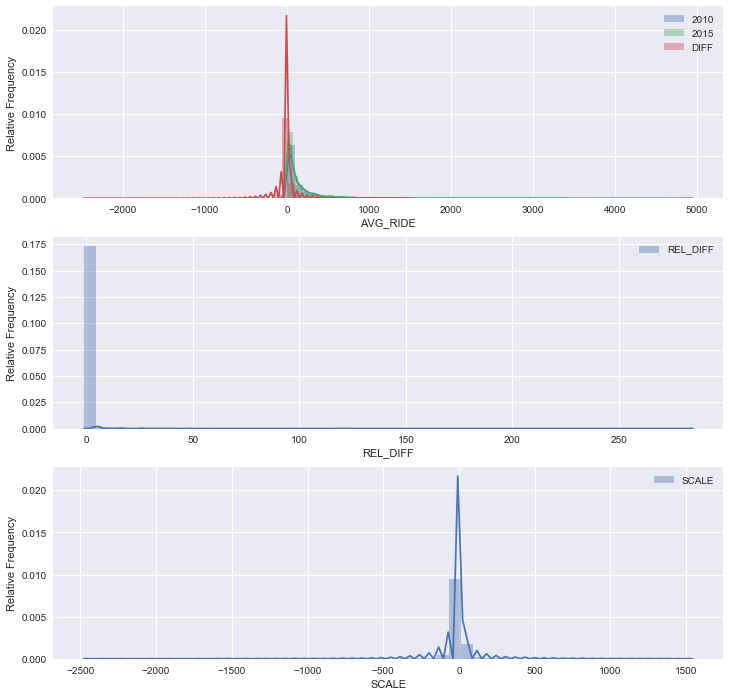

In [7]:
var = 'AVG_RIDE'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

Excluding 5 records with non-finite relative difference.


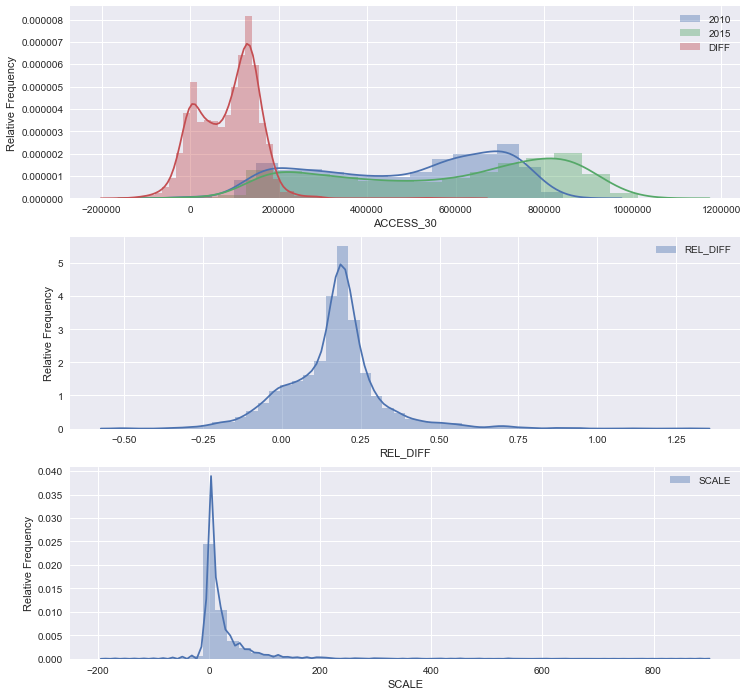

In [8]:
var = 'ACCESS_30'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

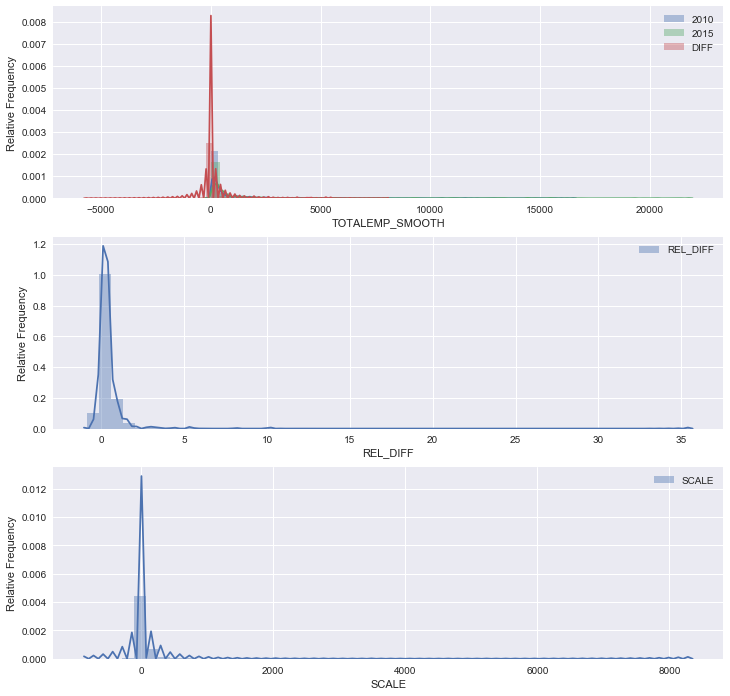

In [9]:
var = 'TOTALEMP_SMOOTH'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

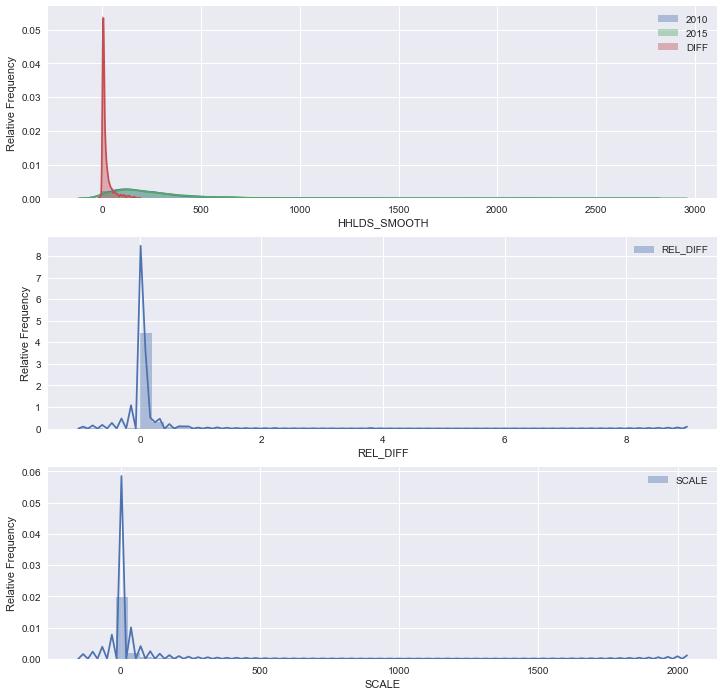

In [10]:
var = 'HHLDS_SMOOTH'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

Excluding 20 records with non-finite relative difference.


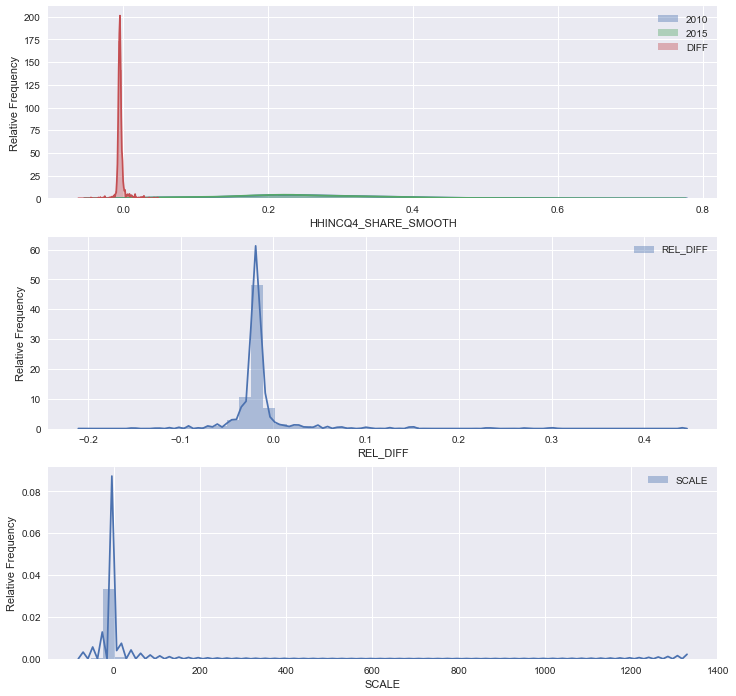

In [11]:
var = 'HHINCQ4_SHARE_SMOOTH'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data2[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data2[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data2[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

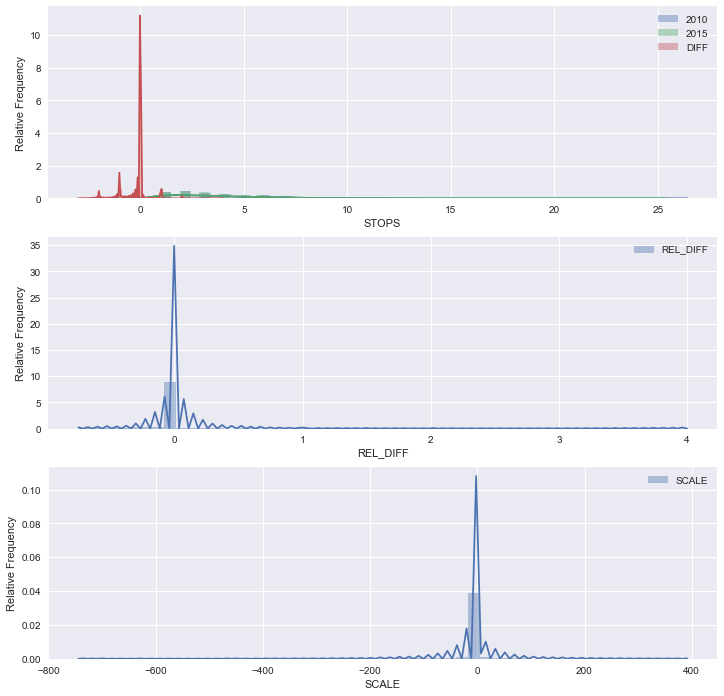

In [12]:
var = 'STOPS'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

Excluding 51 records with non-finite relative difference.


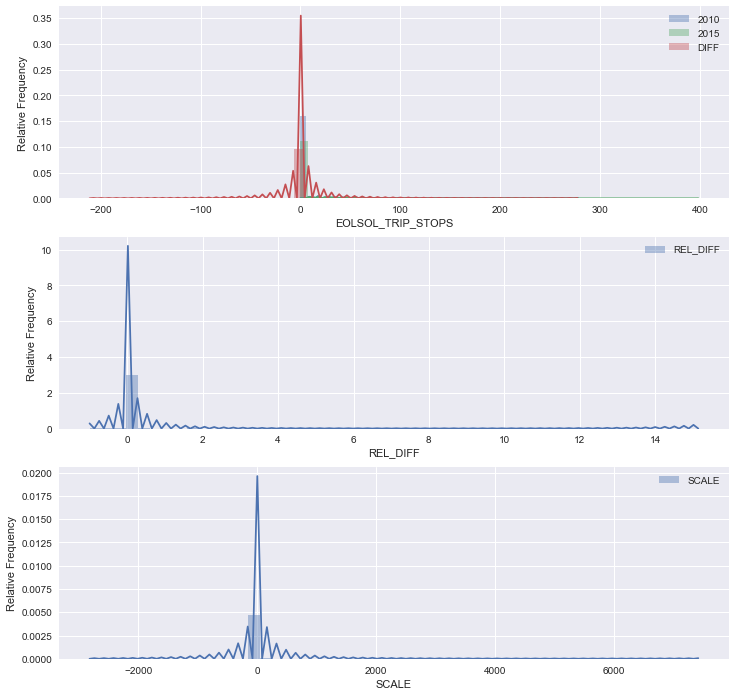

In [13]:
var = 'EOLSOL_TRIP_STOPS'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

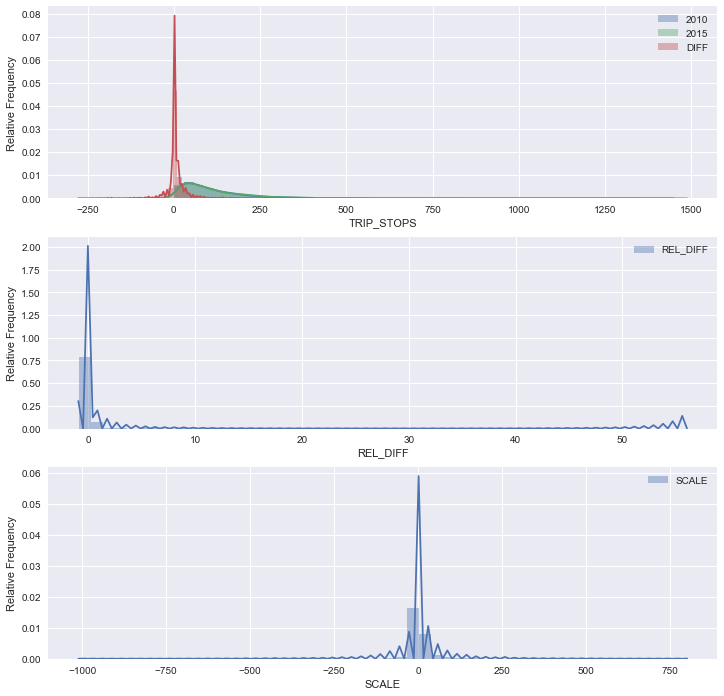

In [14]:
var = 'TRIP_STOPS'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

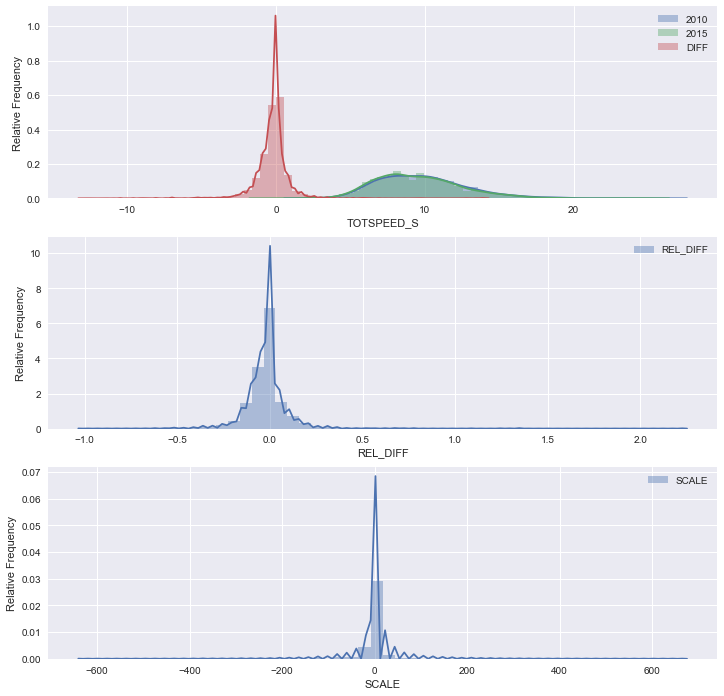

In [15]:
var = 'TOTSPEED_S'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

Excluding 7 records with non-finite relative difference.


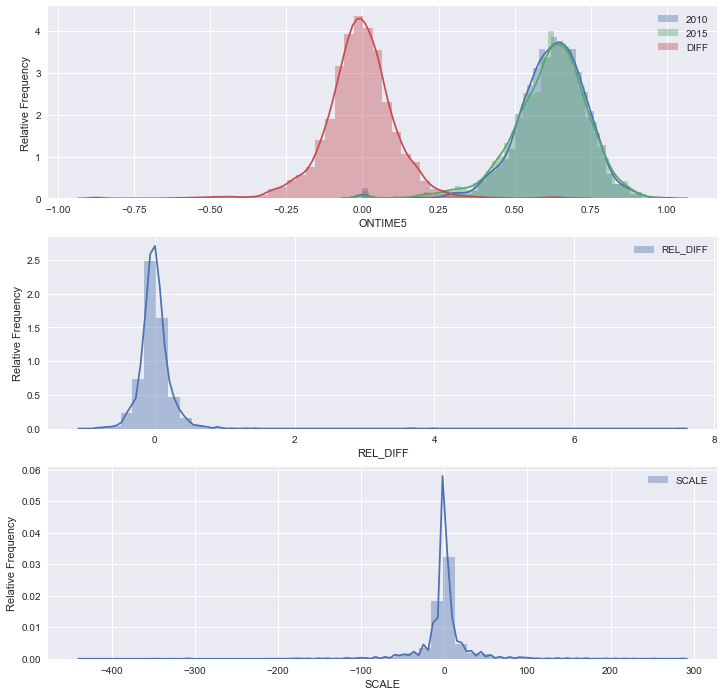

In [16]:
var = 'ONTIME5'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

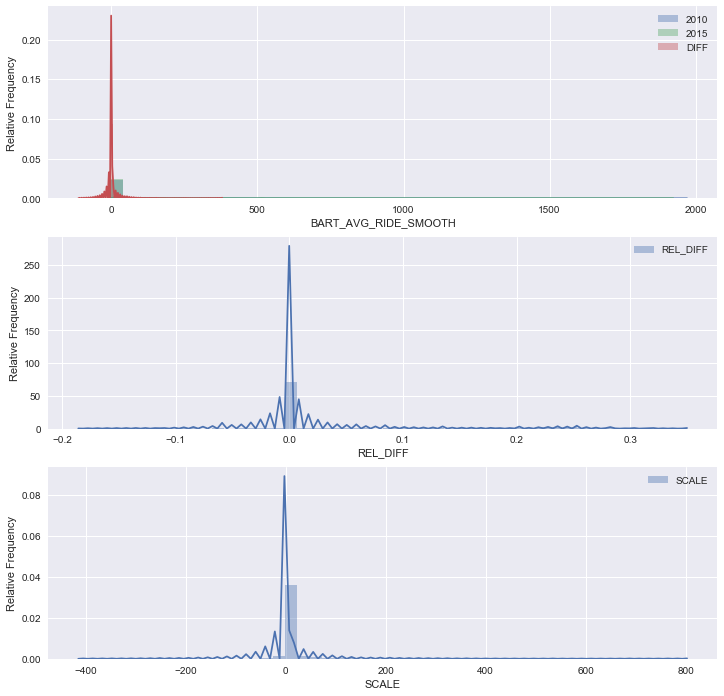

In [17]:
var = 'BART_AVG_RIDE_SMOOTH'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

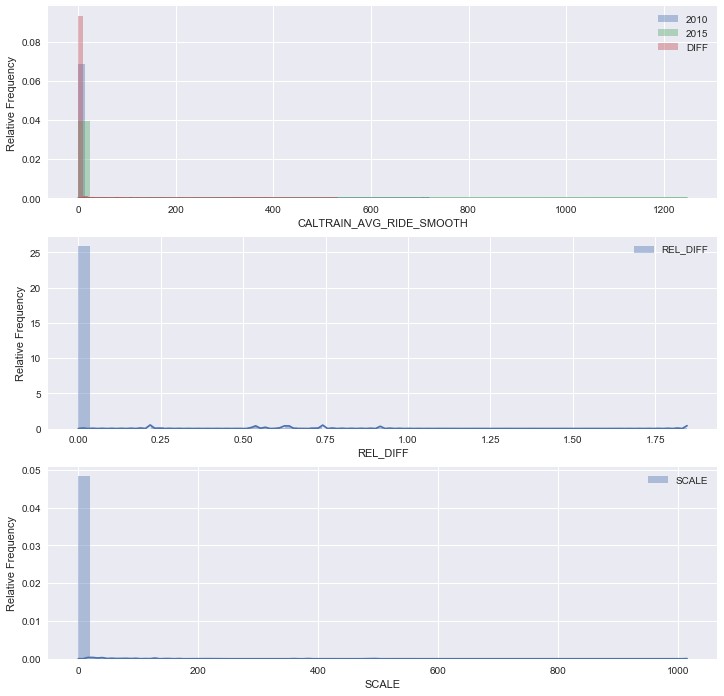

In [18]:
var = 'CALTRAIN_AVG_RIDE_SMOOTH'
scale_type = 'SCALE'

# check if everything will plot
data2 = data[np.isfinite(data[var+'_REL_DIFF'])]
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite relative difference.')

# below is generic
f, axes = plt.subplots(3, 1, figsize=(12, 12))

# the values and the difference
sns.distplot(data[var+'_2010'], label='2010', ax=axes[0])
sns.distplot(data[var+'_2015'], label='2015', ax=axes[0])
sns.distplot(data[var+'_DIFF'], label='DIFF', ax=axes[0])
axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel(var)
axes[0].legend()

# the relative difference
sns.distplot(data2[var+'_REL_DIFF'], label='REL_DIFF', ax=axes[1])
axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('REL_DIFF')
axes[1].legend()

# the scale (relative difference times 2010 ridership)
if scale_type == 'SCALE': 
    sns.distplot(data2[var+'_SCALE'], label='SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('SCALE')
    axes[2].legend()
    
# the flag scale (difference times 2010 ridership)    
else: 
    sns.distplot(data[var+'_FLAG_SCALE'], label='FLAG_SCALE', ax=axes[2])
    axes[2].set_ylabel('Relative Frequency')
    axes[2].set_xlabel('FLAG_SCALE')
    axes[2].legend()
    
plt.show()

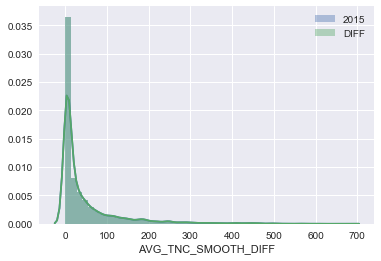

In [19]:
var = 'AVG_TNC_SMOOTH'

# check if everything will plot
data3 = data[np.isfinite(data[var+'_2015'])]
len_diff = len(data) - len(data3)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with non-finite 2015 values.')

# the values and the difference
sns.distplot(data3[var+'_2015'], label='2015')
sns.distplot(data3[var+'_DIFF'], label='DIFF')
plt.legend()

plt.show()

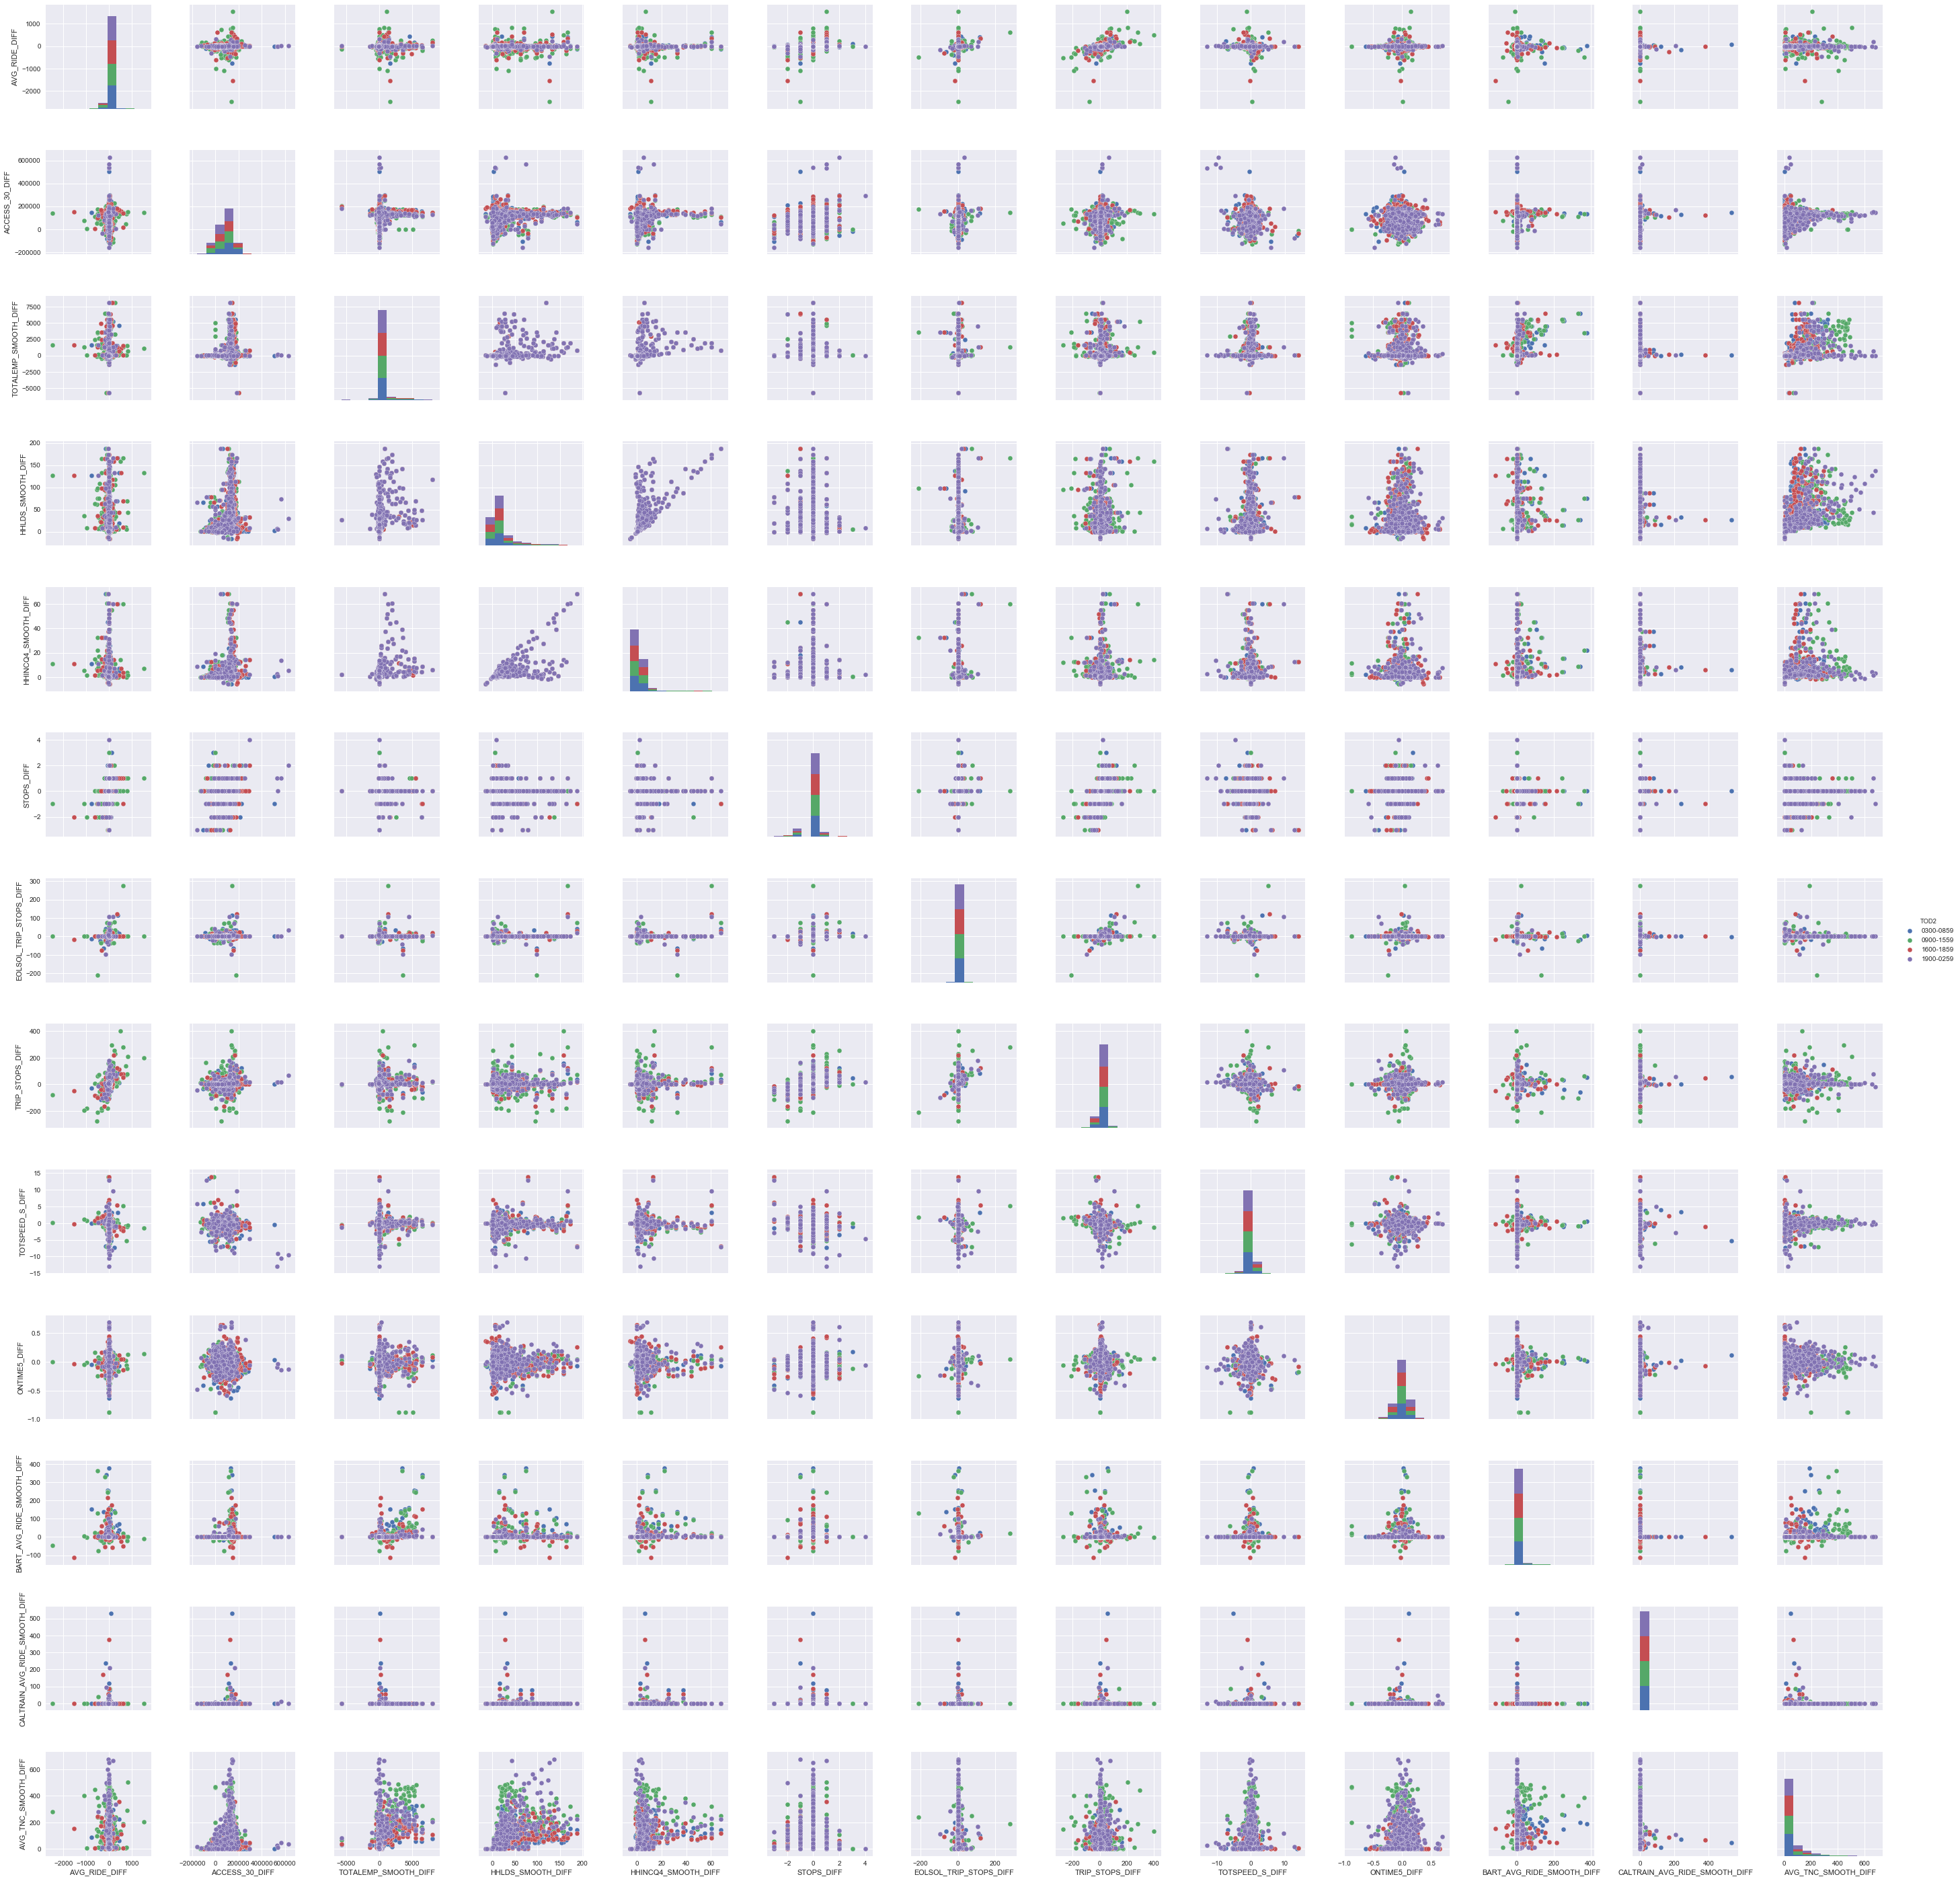

In [20]:
# look at some pair plots

col_type = '_DIFF'

data2 = data.loc[:, [('AVG_RIDE' + col_type), 
                     ('ACCESS_30' + col_type), 
                     ('TOTALEMP_SMOOTH' + col_type), 
                     ('HHLDS_SMOOTH' + col_type), 
                     ('HHINCQ4_SMOOTH' + col_type), 
                     #('HH_0VEH' + col_type), 
                     ('STOPS' + col_type), 
                     ('EOLSOL_TRIP_STOPS' + col_type), 
                     ('TRIP_STOPS' + col_type), 
                     ('TOTSPEED_S' + col_type), 
                     ('ONTIME5' + col_type), 
                     #('COMP_TRANSIT_STOPS' + col_type),  
                     ('BART_AVG_RIDE_SMOOTH' + col_type), 
                     ('CALTRAIN_AVG_RIDE_SMOOTH' + col_type), 
                     ('AVG_TNC_SMOOTH' + col_type), 
                     ('TOD2')]]

# check for missing data
data2 = data2.replace([np.inf, -np.inf], np.nan)
data2 = data2.dropna()
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(data2, hue=('TOD2'), dropna=True, size=3)
plt.savefig('pairplot_bus_' + col_type + '.png')


In [21]:
# show the correlation matrix
data2.corr().style.background_gradient(cmap='Reds')

Excluding 66 records with missing values.


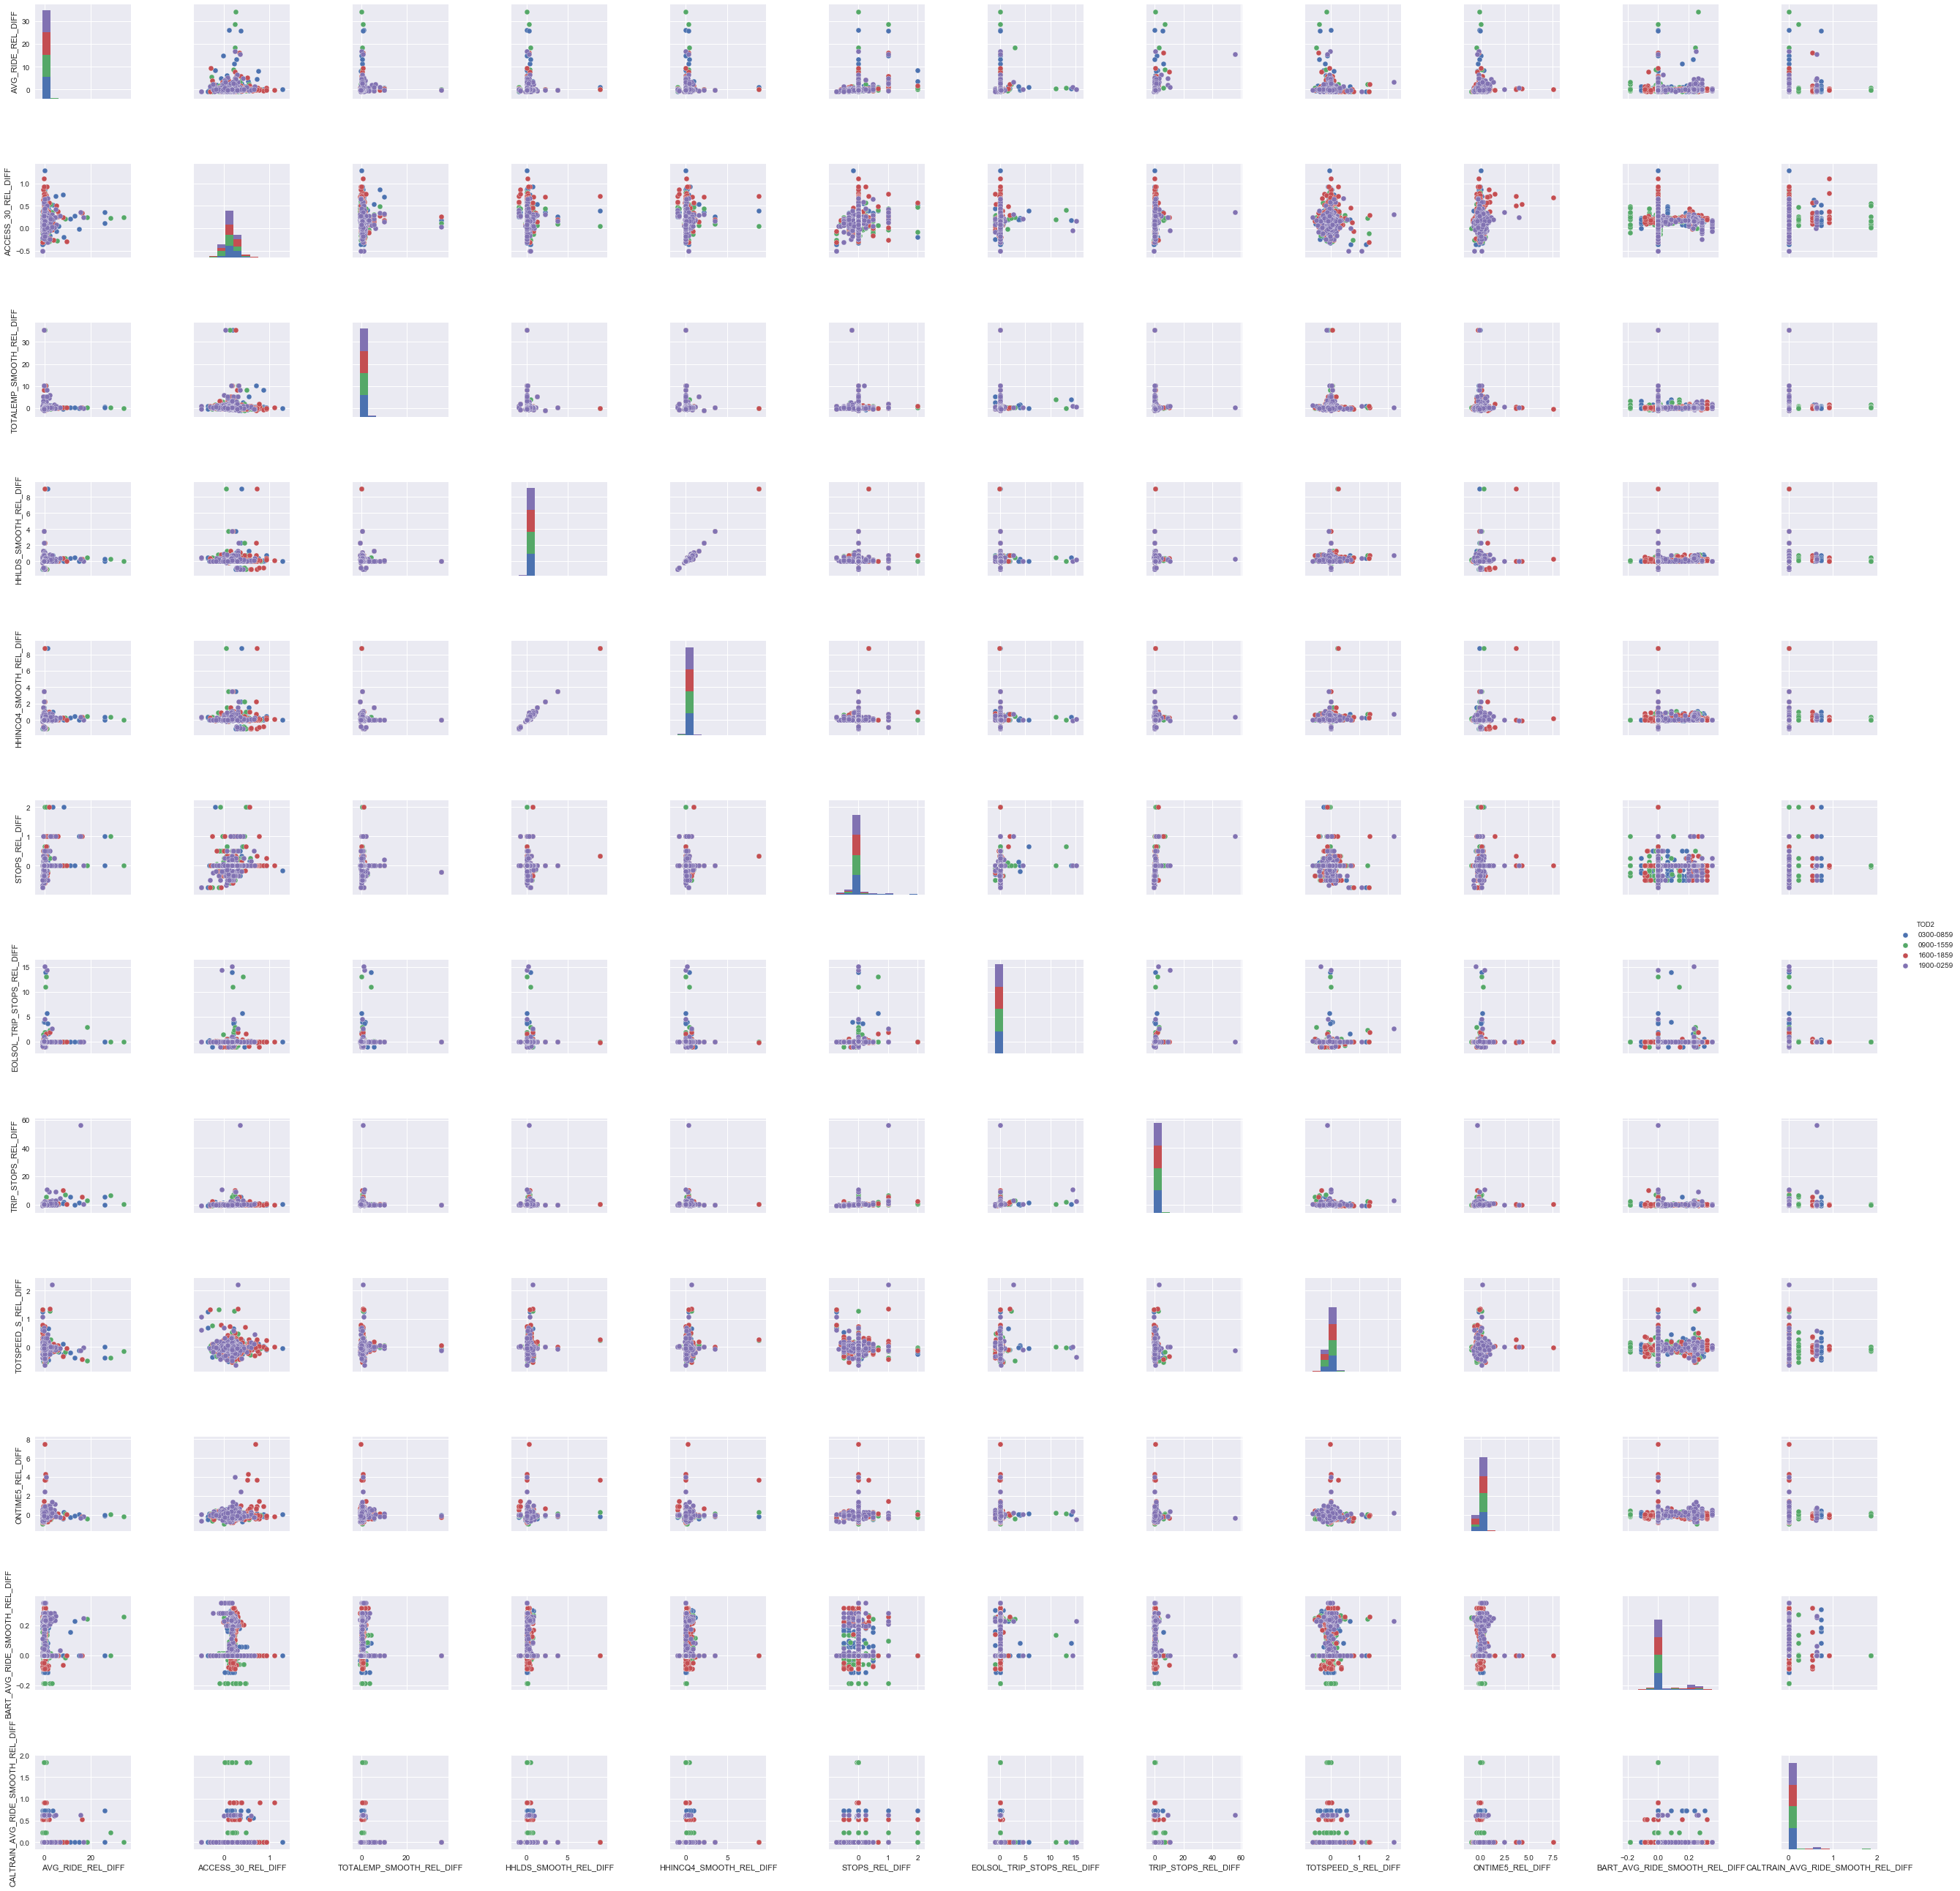

In [22]:
# look at some pair plots

col_type = '_REL_DIFF'

data2 = data.loc[:, [('AVG_RIDE' + col_type), 
                     ('ACCESS_30' + col_type), 
                     ('TOTALEMP_SMOOTH' + col_type), 
                     ('HHLDS_SMOOTH' + col_type), 
                     ('HHINCQ4_SMOOTH' + col_type), 
                     #('HH_0VEH' + col_type), 
                     ('STOPS' + col_type), 
                     ('EOLSOL_TRIP_STOPS' + col_type), 
                     ('TRIP_STOPS' + col_type), 
                     ('TOTSPEED_S' + col_type), 
                     ('ONTIME5' + col_type), 
                     #('COMP_TRANSIT_STOPS' + col_type),  
                     ('BART_AVG_RIDE_SMOOTH' + col_type), 
                     ('CALTRAIN_AVG_RIDE_SMOOTH' + col_type), 
                     #('AVG_TNC' + col_type), 
                     ('TOD2')]]

# check for missing data
data2 = data2.replace([np.inf, -np.inf], np.nan)
data2 = data2.dropna()
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(data2, hue=('TOD2'), dropna=True, size=3)
plt.savefig('pairplot_bus_' + col_type + '.png')


In [23]:
# show the correlation matrix
data2.corr().style.background_gradient(cmap='Reds')

Excluding 66 records with missing values.


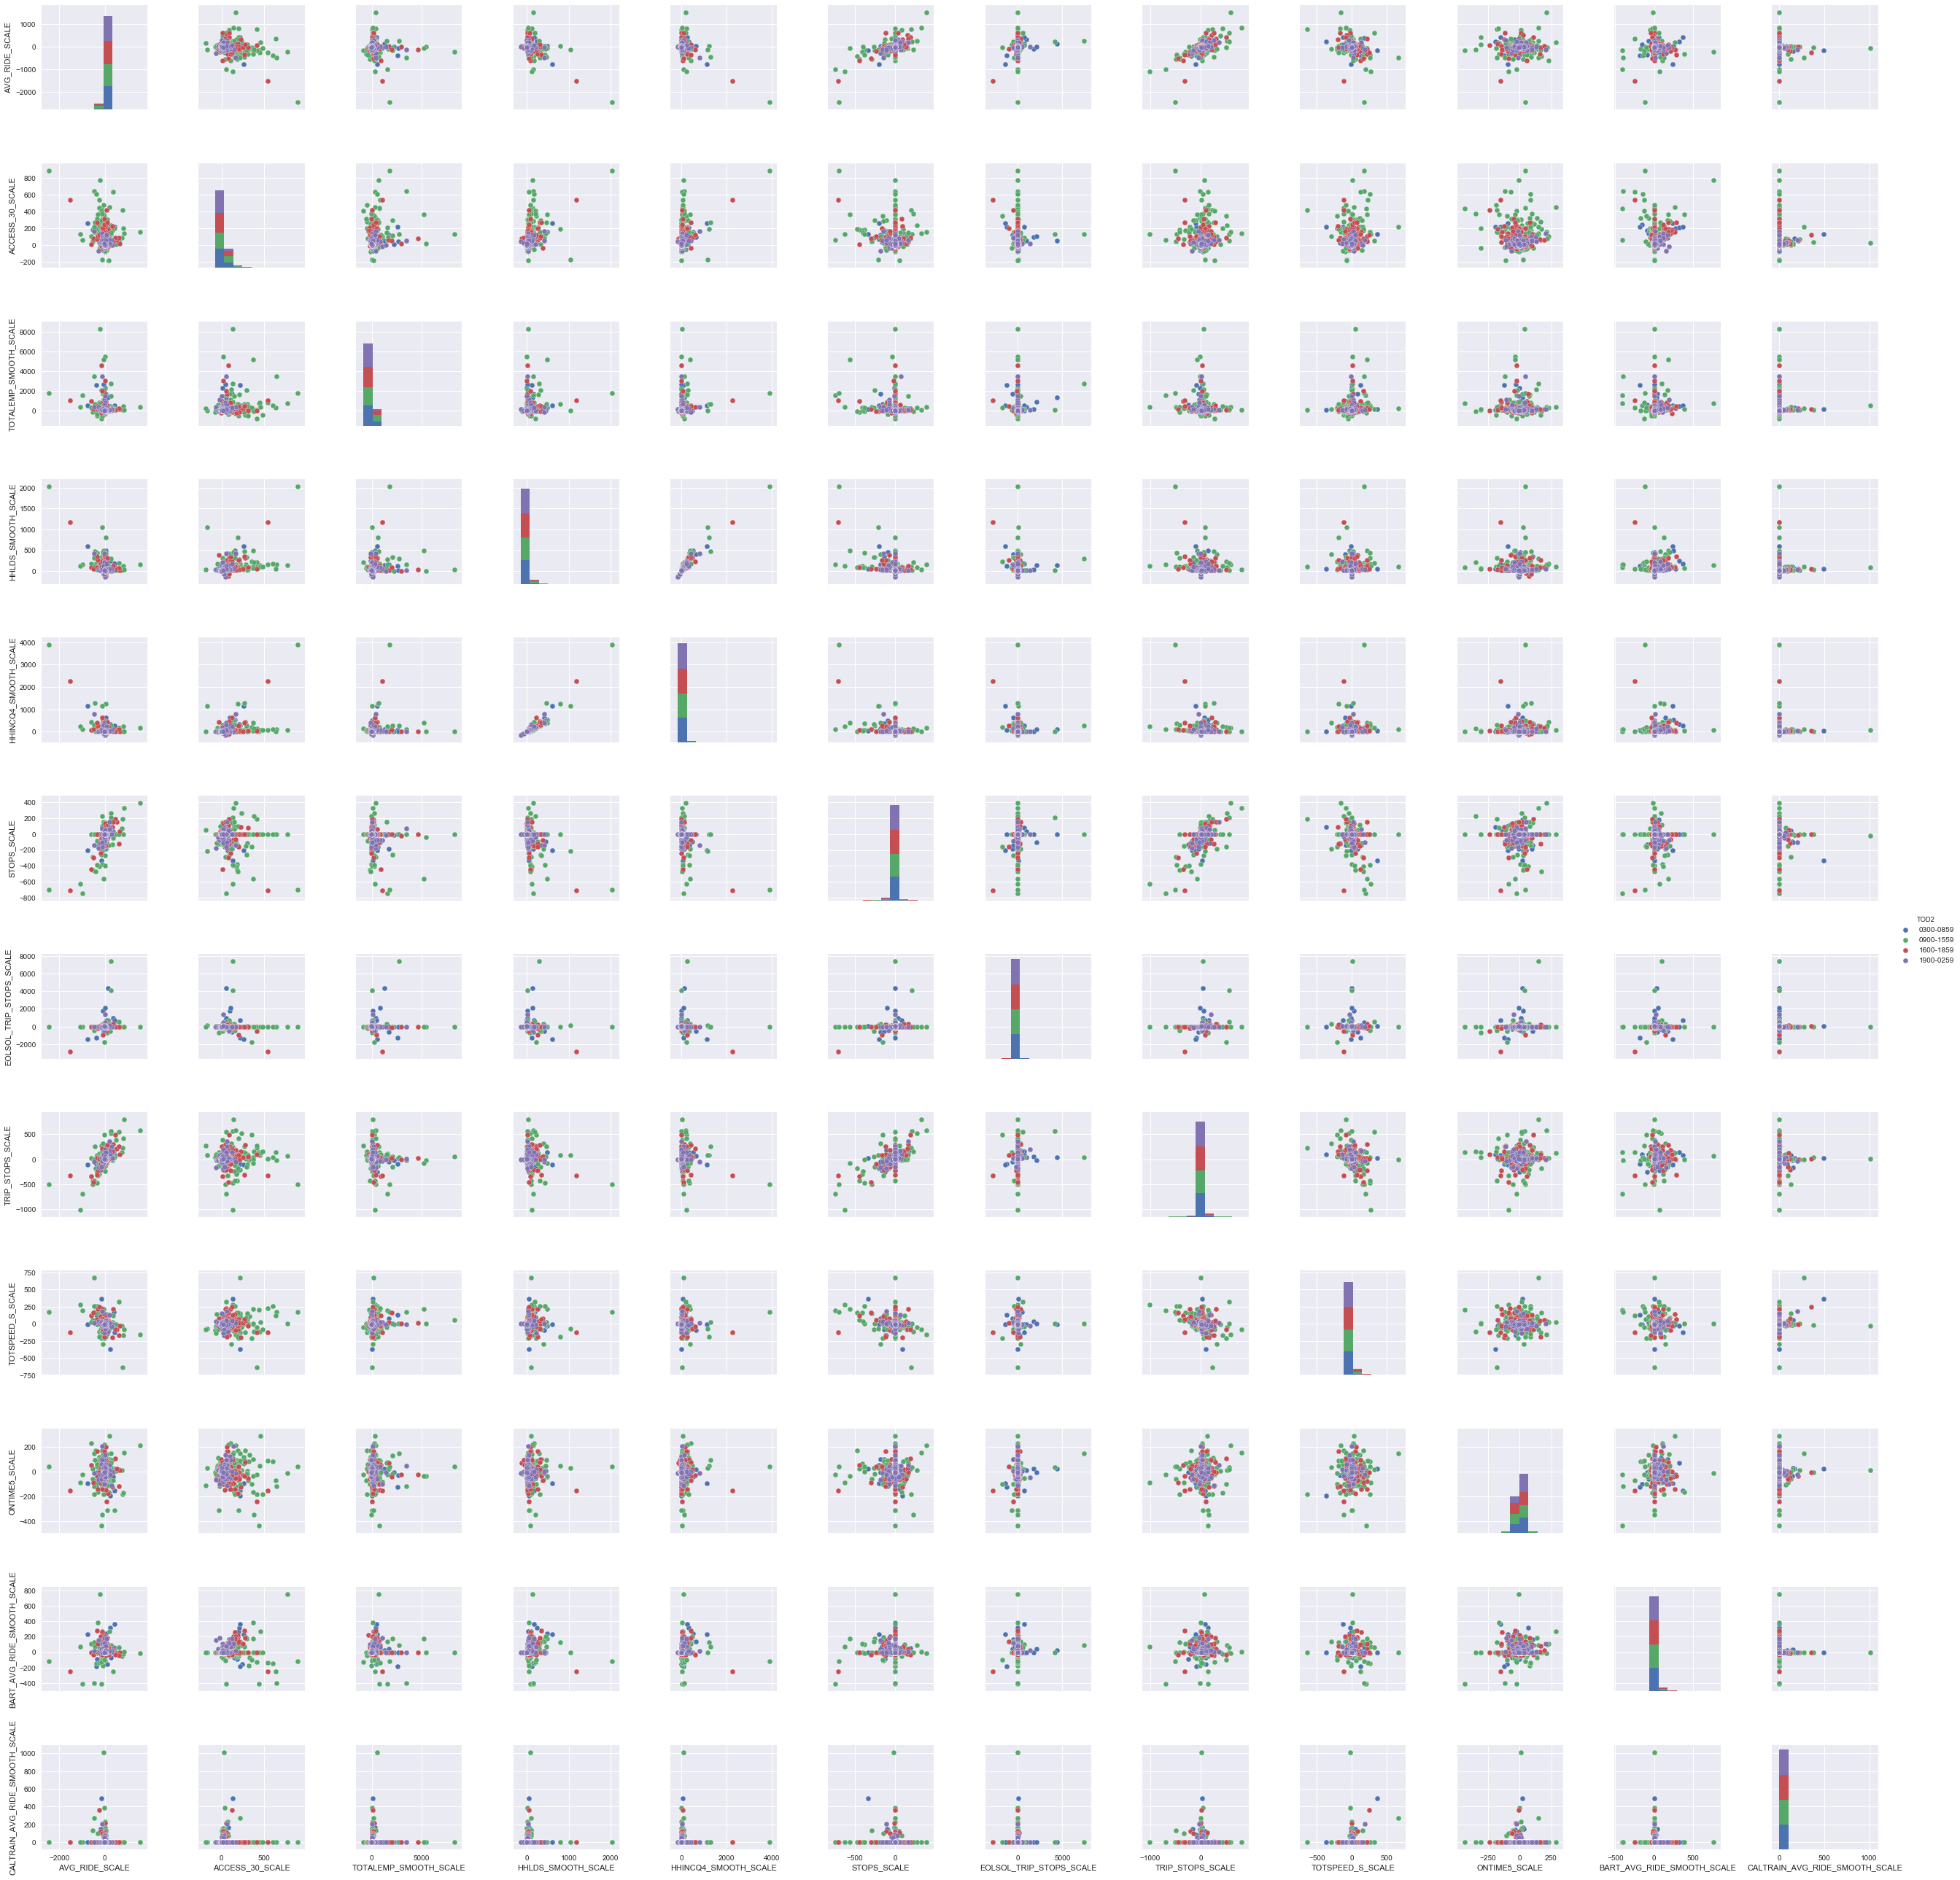

In [24]:
# look at some pair plots

col_type = '_SCALE'


data2 = data.loc[:, [('AVG_RIDE' + col_type), 
                     ('ACCESS_30' + col_type), 
                     ('TOTALEMP_SMOOTH' + col_type), 
                     ('HHLDS_SMOOTH' + col_type), 
                     ('HHINCQ4_SMOOTH' + col_type), 
                     #('HH_0VEH' + col_type), 
                     ('STOPS' + col_type), 
                     ('EOLSOL_TRIP_STOPS' + col_type), 
                     ('TRIP_STOPS' + col_type), 
                     ('TOTSPEED_S' + col_type), 
                     ('ONTIME5' + col_type), 
                     #('COMP_TRANSIT_STOPS' + col_type),  
                     ('BART_AVG_RIDE_SMOOTH' + col_type), 
                     ('CALTRAIN_AVG_RIDE_SMOOTH' + col_type), 
                     #('AVG_TNC' + col_type), 
                     ('TOD2')]]

# check for missing data
data2 = data2.replace([np.inf, -np.inf], np.nan)
data2 = data2.dropna()
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(data2, hue=('TOD2'), dropna=True, size=3)
plt.savefig('pairplot_bus_' + col_type + '.png')



In [25]:
# show the correlation matrix
data2.corr().style.background_gradient(cmap='Reds')

Excluding 62 records with missing values.


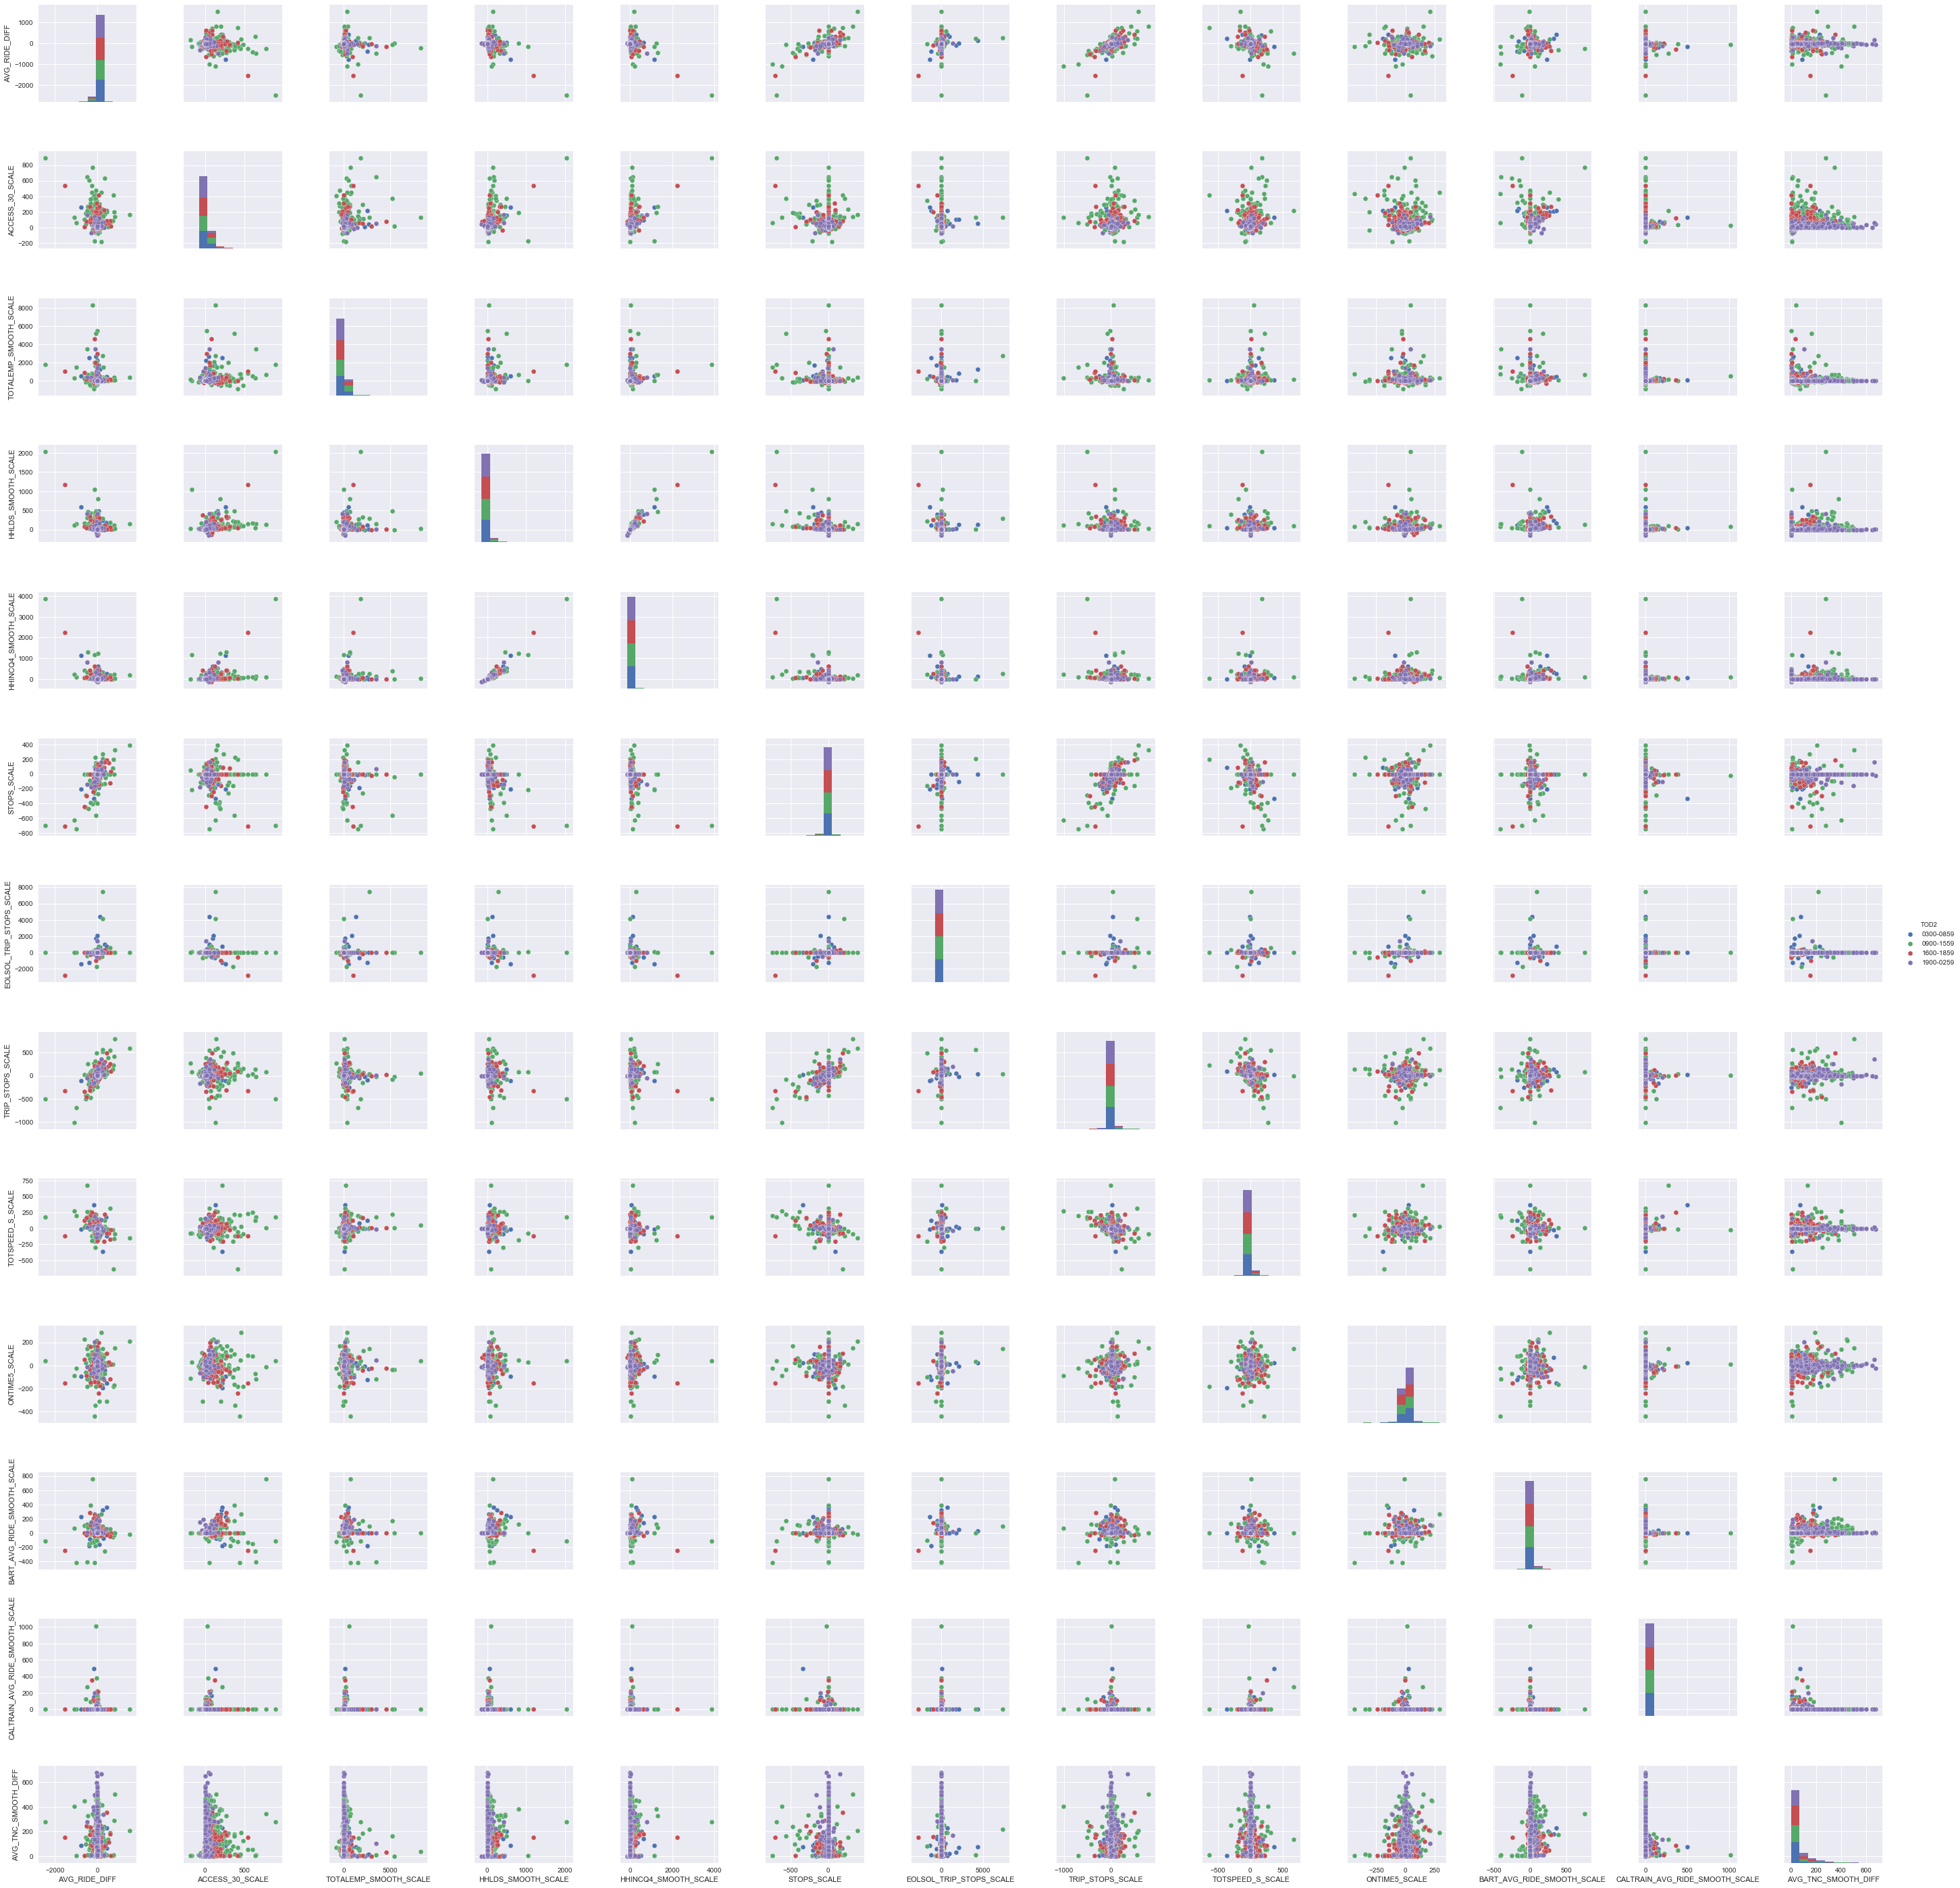

In [26]:
# look at some pair plots

data2 = data.loc[:, [('AVG_RIDE_DIFF'), 
                     ('ACCESS_30_SCALE'), 
                     ('TOTALEMP_SMOOTH_SCALE'), 
                     ('HHLDS_SMOOTH_SCALE'), 
                     ('HHINCQ4_SMOOTH_SCALE'), 
                     #('HH_0VEH_SCALE'),
                     ('STOPS_SCALE'), 
                     ('EOLSOL_TRIP_STOPS_SCALE'), 
                     ('TRIP_STOPS_SCALE'), 
                     ('TOTSPEED_S_SCALE'), 
                     ('ONTIME5_SCALE'), 
                     #('COMP_TRANSIT_STOPS_SCALE'), 
                     ('BART_AVG_RIDE_SMOOTH_SCALE'), 
                     ('CALTRAIN_AVG_RIDE_SMOOTH_SCALE'), 
                     ('AVG_TNC_SMOOTH_DIFF'), 
                     ('TOD2')]]

# check for missing data
data2 = data2.replace([np.inf, -np.inf], np.nan)
data2 = data2.dropna()
len_diff = len(data) - len(data2)
if len_diff>0: 
    print('Excluding ' + str(len_diff) + ' records with missing values.')

plt = sns.pairplot(data2, hue=('TOD2'), dropna=True, size=3)
plt.savefig('pairplot_bus_MIXED.png')


In [27]:
# show the correlation matrix
data2.corr().style.background_gradient(cmap='Reds')